# Geometric Multigrid



<IPython.core.display.Javascript object>


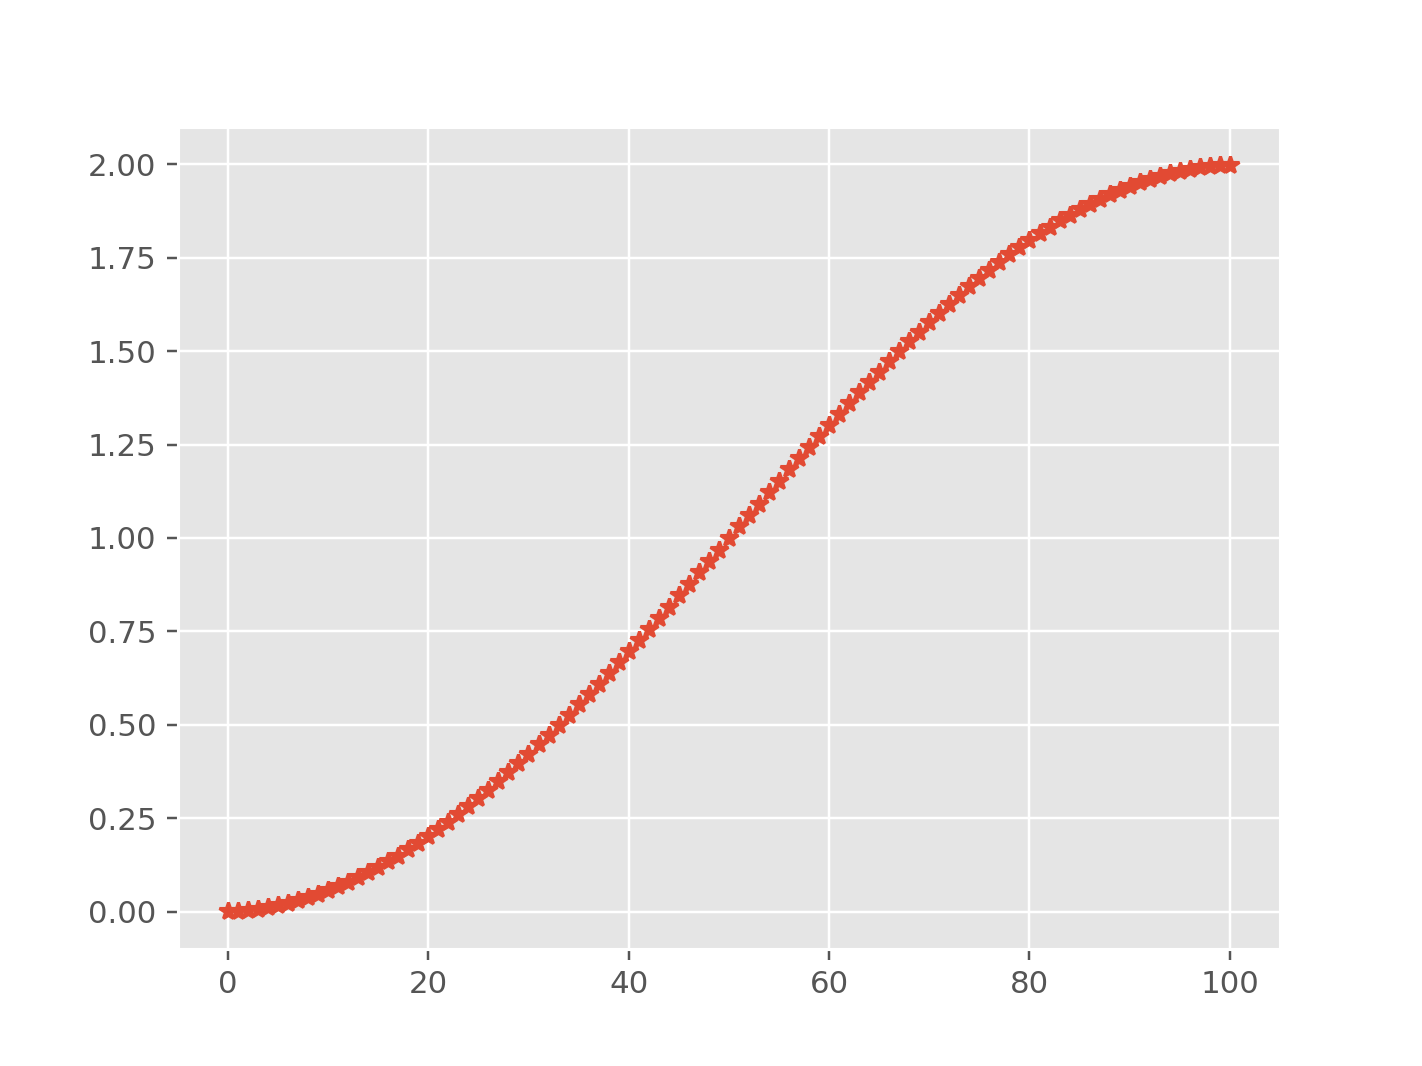

In [34]:
%matplotlib notebook
import numpy

m = 101
A = numpy.eye(m) - .5*numpy.eye(m,k=1) - .5*numpy.eye(m,k=-1)

L, X  = numpy.linalg.eigh(A)

from matplotlib import pyplot
pyplot.style.use('ggplot')
pyplot.figure()
pyplot.plot(L, '*')
pyplot.show()

<IPython.core.display.Javascript object>


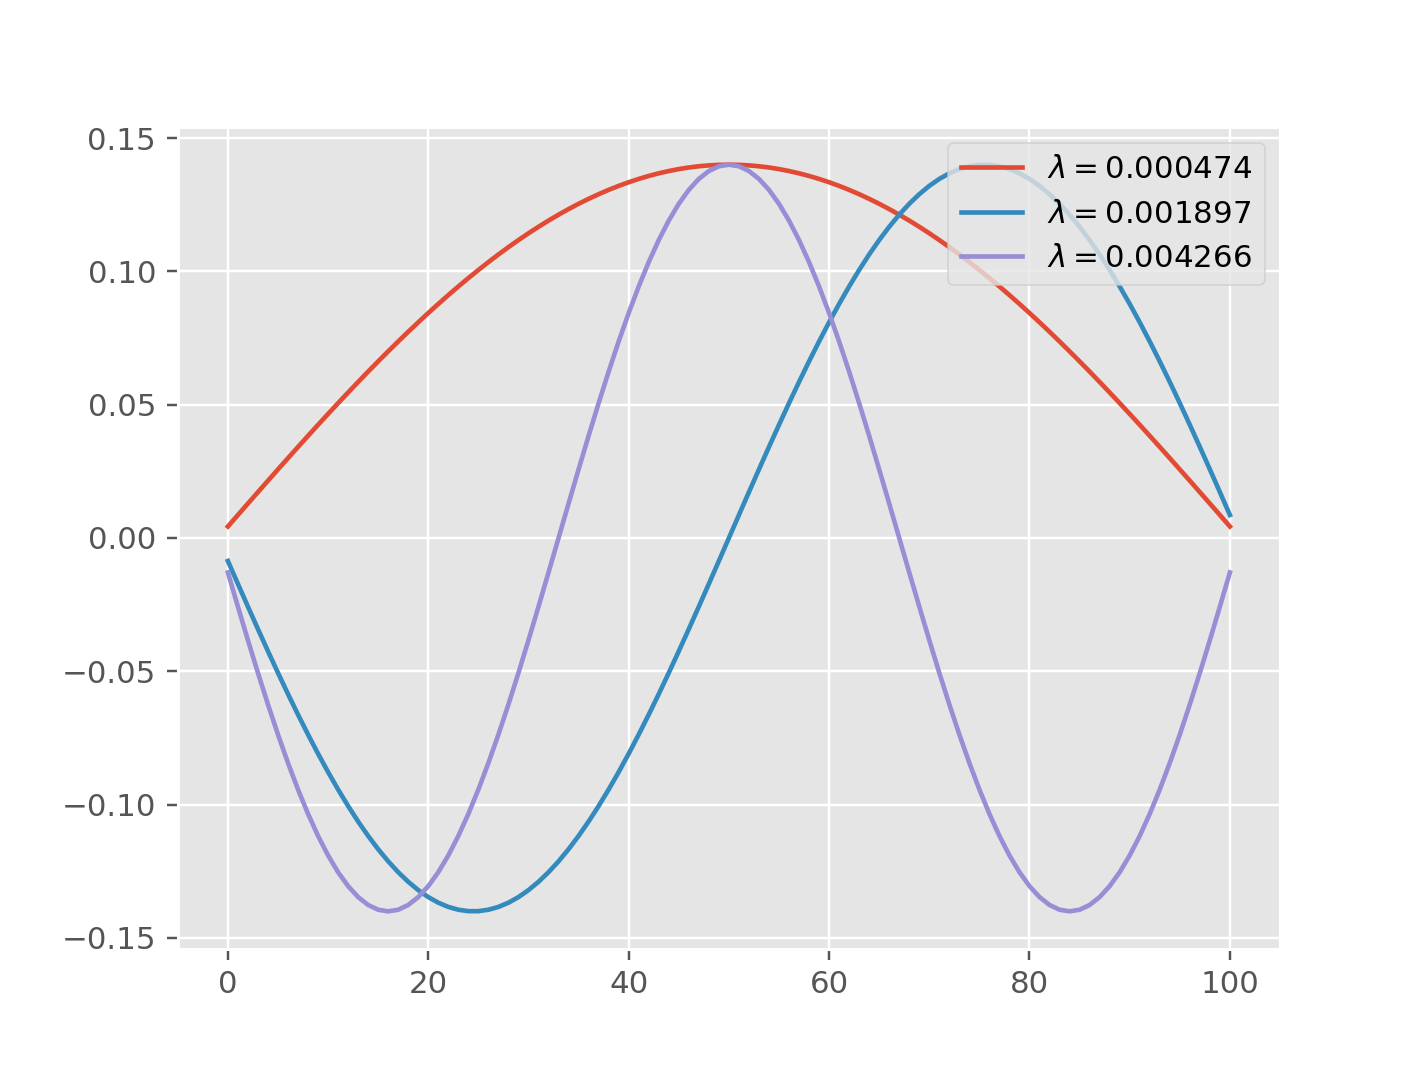

In [35]:
pyplot.figure()
for i in (0,1,2):
    pyplot.plot(X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

<IPython.core.display.Javascript object>


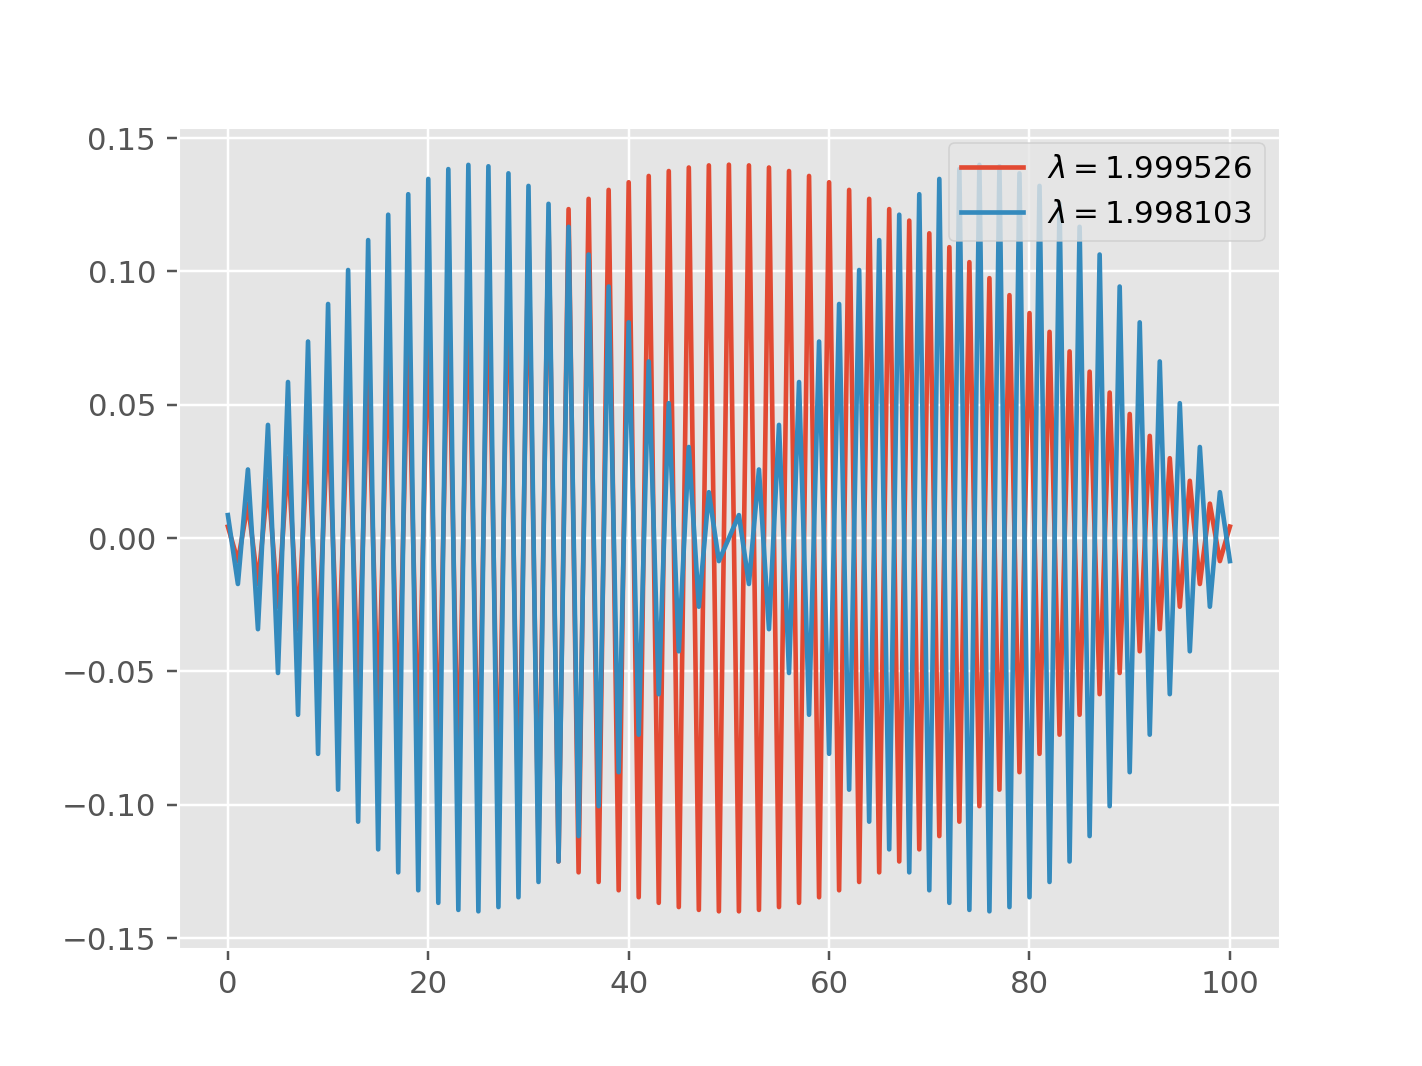

In [37]:
pyplot.figure()
for i in (-1,-2):
    pyplot.plot(X[:,i], label='$\lambda = %f$' % L[i])
pyplot.legend(loc='upper right')
pyplot.show()

In [40]:
P = numpy.eye(m) + .5*numpy.eye(m,k=1) + .5*numpy.eye(m,k=-1)
P = P[:,::2]
P.shape

(101, 51)

<IPython.core.display.Javascript object>


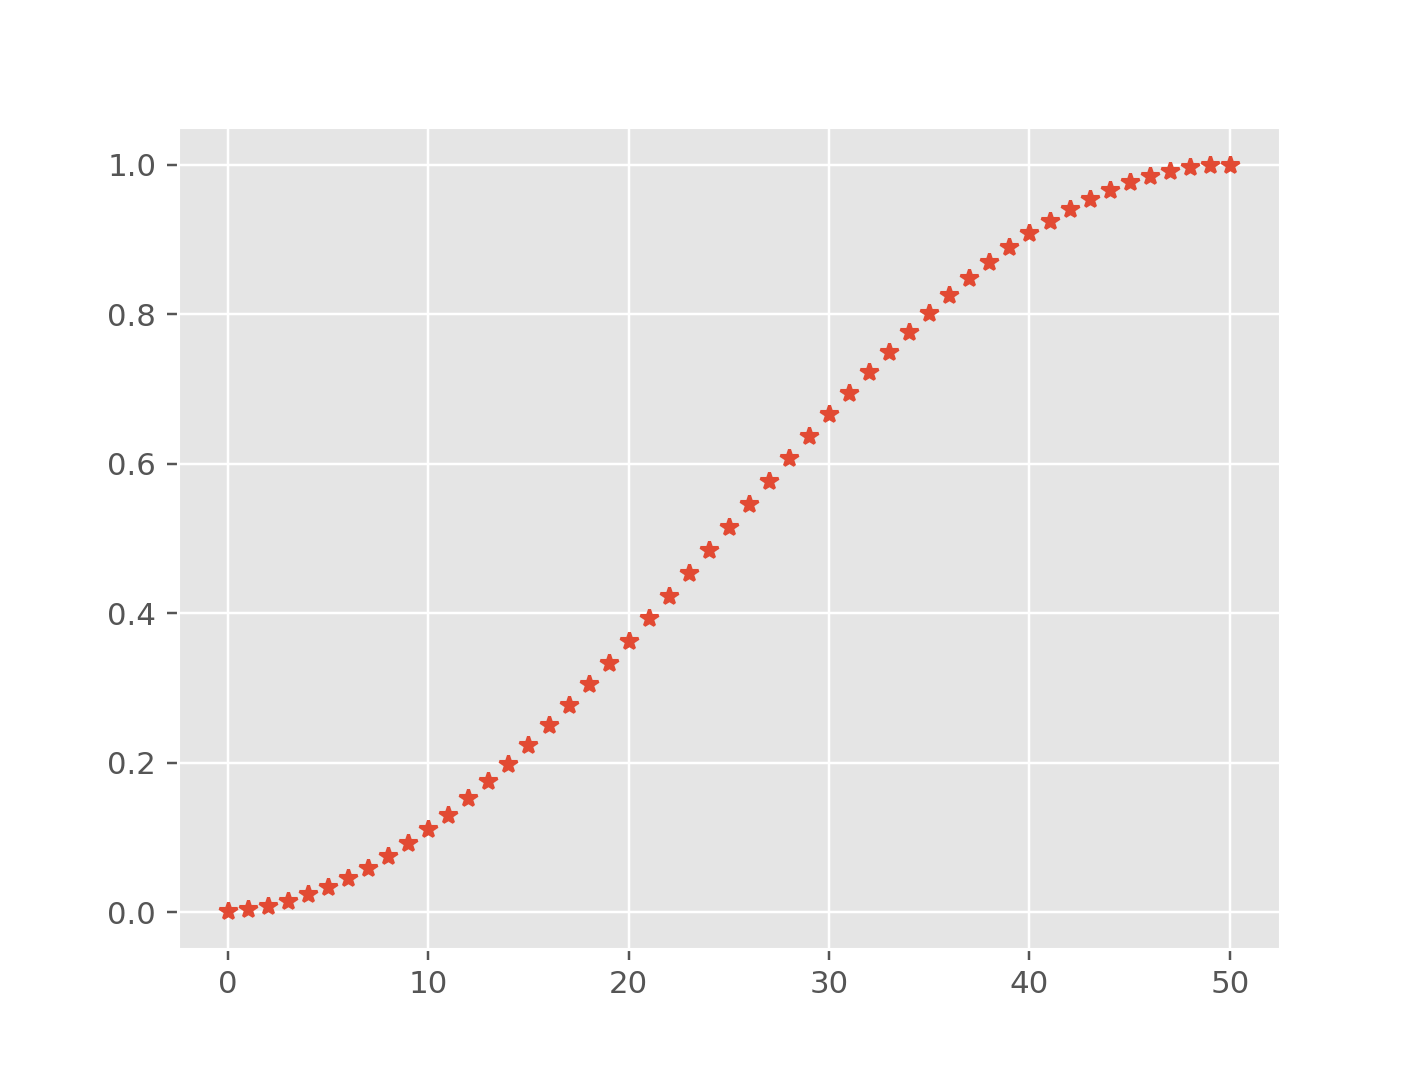

In [43]:
Ac = P.T.dot(A.dot(P))

Lc, Xc = numpy.linalg.eigh(Ac)
pyplot.figure()
pyplot.plot(Lc, '*')

7.18533924784e-15


<IPython.core.display.Javascript object>


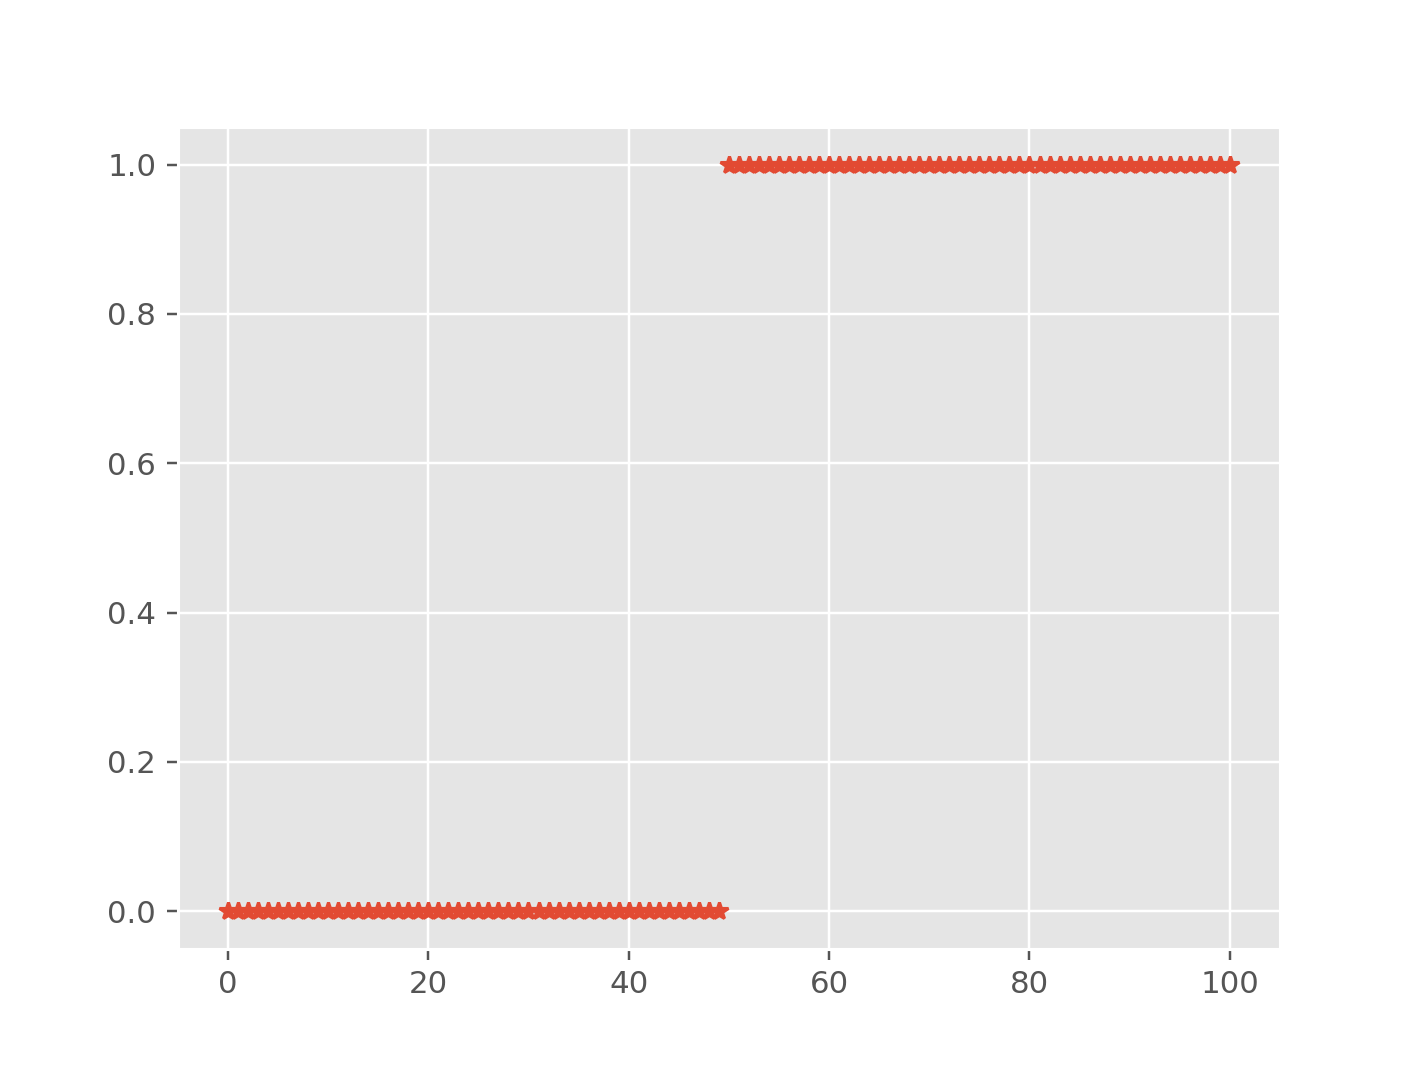

In [52]:
# Consider the A-orthogonal projector into the range of P
Sc = P.dot(numpy.linalg.inv(Ac)).dot(P.T).dot(A)
Ls, Xs = numpy.linalg.eig(Sc)
print(max(abs(Ls.imag)))
Ls = Ls.real
idx = Ls.argsort()
Ls = Ls[idx]; Xs = Xs[:,idx]

pyplot.figure()
pyplot.plot(Ls, '*')

In [ ]:
I = numpy.eye(m)
numpy.linalg.eigh((I - Sc).dot(I - A))